In [2]:
from models import MeshModel, IcosphereModel
from models.mesh_transform import transform
from models.mesh_view import get_mesh_view
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from geometry import clip, polygon_area
from geometry.utils import wrap
from jax.typing import ArrayLike
import jax

from jax import config
config.update("jax_enable_x64", True)

sol_rad = u.solRad.to(u.cm)

m1 = get_mesh_view(IcosphereModel.construct(1000, u.solRad.to(u.cm), 1.*u.solMass.to(u.kg), 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)])), jnp.array([1., 0., 0.]))
m2 = get_mesh_view(transform(IcosphereModel.construct(1000, u.solRad.to(u.cm), 1.*u.solMass.to(u.kg), 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)])),
               jnp.array([3*u.solRad.to(u.cm), 0.25*u.solRad.to(u.cm), 0.])), jnp.array([1., 0., 0.]))

Getting cast areas
Getting cast indexes
Getting cast areas
Getting cast indexes
Getting cast areas
Getting cast indexes
Getting cast areas
Getting cast indexes
Getting cast areas
Getting cast indexes


In [3]:
def visible_area(vertices1: ArrayLike, vertices2: ArrayLike) -> ArrayLike:
    clipped = jnp.nan_to_num(clip(vertices1, vertices2))
    return polygon_area(clipped[:, 0], clipped[:, 1])

total_visible_area = jax.jit(jax.vmap(visible_area, in_axes=(None, 0)))
visibility_areas = jax.jit(jax.vmap(total_visible_area, in_axes=(0, None)))

In [4]:
vs1 = m1.vertices[m1.faces[m1.mus>0].astype(int)]
vs2 = m2.vertices[m2.faces[m2.mus>0].astype(int)]
projected_areas = jax.jit(jax.vmap(polygon_area))
pa = projected_areas(vs1[:, :, 0], vs1[:, :, 2])
occluded = visibility_areas(vs1[:, :, [1, 2]], vs2[:, :, [1, 2]])

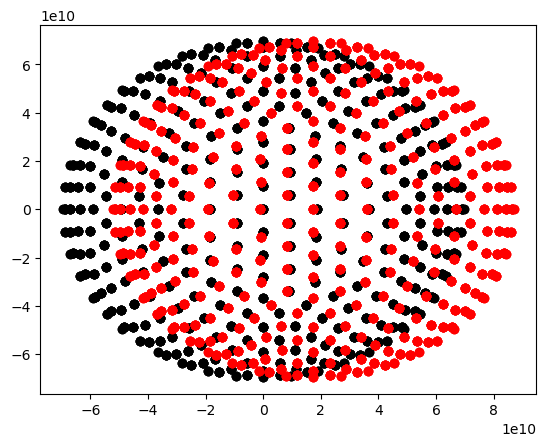

In [4]:
plt.scatter(vs1[:, :, 1], vs1[:, :, 2], c='black')
plt.scatter(vs2[:, :, 1], vs2[:, :, 2], c='red')

In [5]:
nx, ny = jnp.meshgrid(jnp.linspace(jnp.min(jnp.concatenate([vs1[:, :, 1], vs2[:, :, 1]])),
                                   jnp.max(jnp.concatenate([vs1[:, :, 1], vs2[:, :, 1]])), 10),
                      jnp.linspace(jnp.min(jnp.concatenate([vs1[:, :, 2], vs2[:, :, 2]])),
                                   jnp.max(jnp.concatenate([vs1[:, :, 2], vs2[:, :, 2]])), 10))
grid = np.vstack([nx.ravel(), ny.ravel()]).T

In [6]:
x_range = jnp.linspace(jnp.min(jnp.concatenate([vs1[:, :, 1], vs2[:, :, 1]])), jnp.max(jnp.concatenate([vs1[:, :, 1], vs2[:, :, 1]])), 10)
y_range = jnp.linspace(jnp.min(jnp.concatenate([vs1[:, :, 2], vs2[:, :, 2]])), jnp.max(jnp.concatenate([vs1[:, :, 2], vs2[:, :, 2]])), 10)
x_span = x_range[1]-x_range[0]
y_span = y_range[1]-y_range[0]

In [7]:
grid.shape

(100, 2)

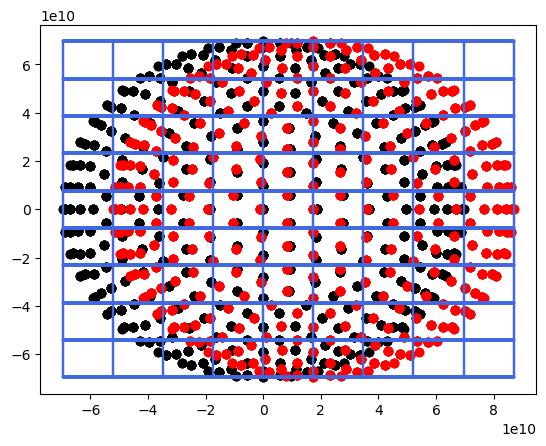

In [8]:
plt.scatter(vs1[:, :, 1], vs1[:, :, 2], c='black')
plt.scatter(vs2[:, :, 1], vs2[:, :, 2], c='red')
for i in range(len(grid)):
    # plt.plot(nx[i, :], ny[i, :], c='royalblue', alpha=0.5)
    # plt.plot(nx[:, i], ny[:, i], c='royalblue', alpha=0.5)
    plt.plot(jnp.repeat(grid[i, 0], len(grid)), grid[:, 1], c='royalblue', alpha=0.5)
    plt.plot(grid[:, 0], jnp.repeat(grid[i, 1], len(grid)), c='royalblue', alpha=0.5)

In [9]:
tzc = jnp.trim_zeros(m1.cast_centers[0])
def get_grid_index(tzc: ArrayLike) -> ArrayLike:
    return jnp.argwhere(np.all(jnp.isclose((tzc-grid)//jnp.array([x_span, y_span]), 0.), axis=1)).flatten()[0].item()

In [10]:
tzc = jnp.trim_zeros(m1.cast_centers[1200])
jnp.argwhere(jnp.all(jnp.isclose((tzc-grid)//jnp.array([x_span, y_span]), 0.), axis=1))

Array([[3]], dtype=int64)

Number of labels: 3840


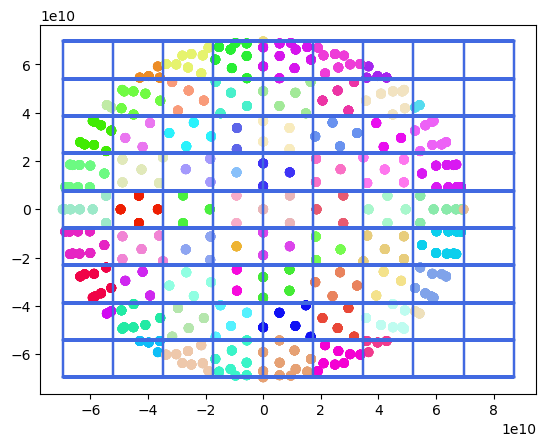

In [11]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    return random_colormap

cv1 = m1.cast_vertices[m1.faces.astype(int)][:, :, 1:].reshape((-1, 2))
new_cmap = rand_cmap(len(cv1), type='bright', first_color_black=True, last_color_black=False)

plt.scatter(cv1[:, 0], cv1[:, 1], c=[new_cmap(get_grid_index(cv1i)) for cv1i in cv1])
for i in range(len(grid)):
    # plt.plot(nx[i, :], ny[i, :], c='royalblue', alpha=0.5)
    # plt.plot(nx[:, i], ny[:, i], c='royalblue', alpha=0.5)
    plt.plot(jnp.repeat(grid[i, 0], len(grid)), grid[:, 1], c='royalblue', alpha=0.5)
    plt.plot(grid[:, 0], jnp.repeat(grid[i, 1], len(grid)), c='royalblue', alpha=0.5)

/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_38700/4181531243.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('turbo')


(-86962500000.0, 86962500000.0)

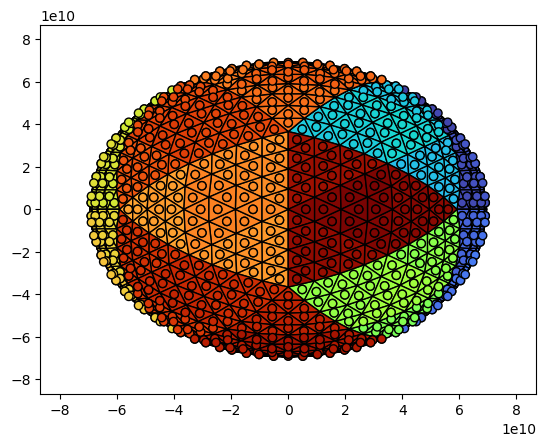

In [12]:
from matplotlib.collections import PolyCollection
import matplotlib

cmap = matplotlib.cm.get_cmap('turbo')
color_indices = np.linspace(0., 1., len(m1.faces))

fig, ax = plt.subplots(1, 1)
pc = PolyCollection(m1.cast_vertices[m1.faces.astype(int)][:, :, 1:], color=cmap(color_indices), edgecolor="black")
ax.add_artist(pc)
ax.scatter(m1.cast_centers[:, 1], m1.cast_centers[:, 2], c=cmap(color_indices), edgecolors='black')

ax.set_xlim(-1.25*m1.radius, 1.25*m1.radius)
ax.set_ylim(-1.25*m1.radius, 1.25*m1.radius)

In [13]:
len(m1.cast_centers)

1280

In [20]:
from collections import defaultdict

grids_m1 = jnp.nan*jnp.ones((grid.shape[0], m1.cast_centers.shape[0]))
reverse_grids_m1 = jnp.nan*jnp.ones((m1.cast_centers.shape[0]))
grids_m2 = jnp.nan*jnp.ones((grid.shape[0], m2.cast_centers.shape[0]))
reverse_grids_m2 = jnp.nan*jnp.ones((m2.cast_centers.shape[0]))

In [41]:
from geometry.utils import append_value_to_last_nan

for i in range(len(m1.cast_centers)):
    grid_index = get_grid_index(m1.cast_centers[i, 1:])
    grids_m1 = grids_m1.at[grid_index].set(append_value_to_last_nan(grids_m1[grid_index], i))
    reverse_grids_m1 = reverse_grids_m1.at[i].set(grid_index)
    
for i in range(len(m2.cast_centers)):
    grid_index = get_grid_index(m2.cast_centers[i, 1:])
    grids_m2 = grids_m2.at[grid_index].set(append_value_to_last_nan(grids_m2[grid_index], i))
    reverse_grids_m2 = reverse_grids_m2.at[i].set(grid_index)

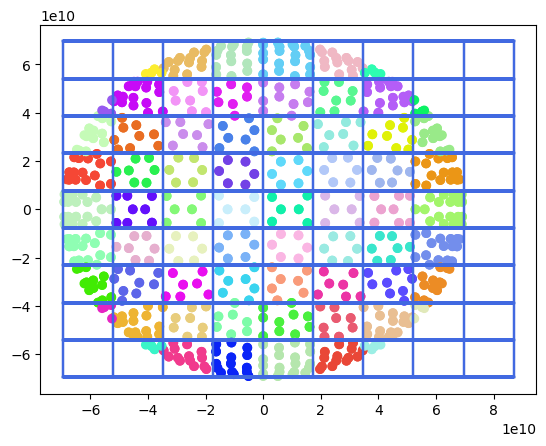

In [31]:
n = matplotlib.colors.Normalize(vmin=0, vmax=len(reverse_grids_m1))

plt.scatter(m1.cast_centers[:, 1], m1.cast_centers[:, 2], c=new_cmap(n(reverse_grids_m1)))

for i in range(len(grid)):
    plt.plot(jnp.repeat(grid[i, 0], len(grid)), grid[:, 1], c='royalblue', alpha=0.5)
    plt.plot(grid[:, 0], jnp.repeat(grid[i, 1], len(grid)), c='royalblue', alpha=0.5)

In [34]:
face_index = 10
vs1[face_index][:, [1, 2]].shape, vs2[jnp.array(grids_m2[reverse_grids_m1[face_index].astype(int)]).astype(int)][:, :, [1, 2]].shape

((3, 2), (1280, 3, 2))

In [36]:
vs2[m2.faces[jnp.array(grids_m2[reverse_grids_m1[face_index].astype(int)]).astype(int)].astype(int)].shape

(1280, 3, 3, 3)

In [42]:
i = 15
face_index = 10
occl = lambda face_index: jnp.sum(total_visible_area(vs1[face_index][:, [1, 2]], vs2[jnp.array(grids_m2[reverse_grids_m1[face_index].astype(int)]).astype(int)][:, :, [1, 2]]))

In [43]:
occl_vmap = jax.vmap(occl)

In [45]:
occluded = occl_vmap(jnp.arange(len(m1.faces)))
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
# p1 = ax.scatter(m1.centers[m1.mus>0, 0], m1.centers[m1.mus>0, 2], c=jnp.clip(jnp.sum(occluded, axis=1)/projected_areas(vs1[:, :, 0], vs1[:, :, 2]), 0, 1), cmap='turbo')
# plt.colorbar(p1, ax=ax)

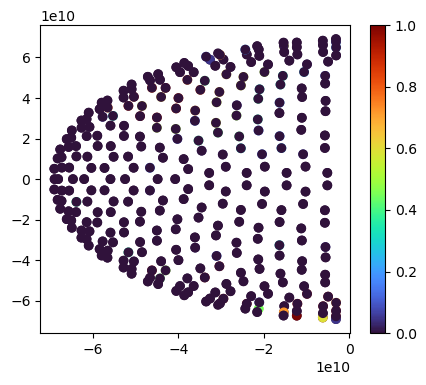

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
p1 = ax.scatter(m1.centers[m1.mus>0, 0], m1.centers[m1.mus>0, 2], c=jnp.clip(occluded[m1.mus>0]/projected_areas(vs1[:, :, 0], vs1[:, :, 2]), 0, 1), cmap='turbo')
plt.colorbar(p1, ax=ax)

(-100000000000.0, 100000000000.0)

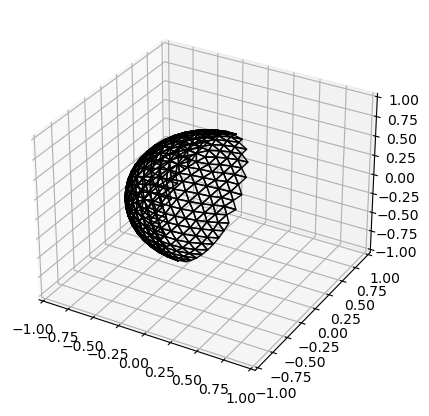

In [50]:
from mpl_toolkits.mplot3d import Axes3D, art3d
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection="3d")
c=jnp.clip(occluded[m1.mus>0]/projected_areas(vs1[:, :, 0], vs1[:, :, 2]), 0, 1)
# c=jnp.clip(jnp.sum(a, axis=1)/projected_areas(vs1[:, :, 0], vs1[:, :, 2]), 0, 1)
n = plt.Normalize(np.min(c), np.max(c))

pc = art3d.Poly3DCollection(vs1, facecolors=plt.cm.turbo(n(c)), edgecolor="black")
ax.add_collection(pc)
ax.set_xlim(-1e11, 1e11)
ax.set_ylim(-1e11, 1e11)
ax.set_zlim(-1e11, 1e11)